In [2]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [196]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning - exploring predictions of mean telomere length post-therapy

In [335]:
# predicting mean telomere length at three months post-therapy (4 C) using individual telomere lengths (FISH)

## Loading/merging data for ML

In [150]:
# loading individual telo data
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')

# loading mean telomere length @ 4 C
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [229]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                             all_patients_df=all_patients_df)

telo_data.head()

,patient id,timepoint,individual telomeres,4 C telo means
0,1,1 non irrad,92.916201,99.346299
1,1,2 irrad @ 4 Gy,112.977654,99.346299
2,1,1 non irrad,65.463687,99.346299
3,1,2 irrad @ 4 Gy,104.530726,99.346299
4,1,1 non irrad,61.240223,99.346299


## Train/test split 

In [281]:
telo_test = telo_data.copy()

y = telo_test[['4 C telo means']]
X = telo_test.drop(['4 C telo means'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [282]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [232]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=0)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning/modeling data with pipeline

In [283]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

In [287]:
train_clean.head()

,individual telomeres,4 C telo means,timepoint_1
0,116.406354,107.674947,1
1,75.263482,107.674947,0
2,125.648045,99.346299,0
3,90.680903,73.988380,1
4,105.465833,73.988380,1


## GridSearch for pipeline/model params

In [125]:
#XGBoost params for grid search
param_grid = {'XGB__max_depth': [3, 7, 9],
              'XGB__learning_rate': [0.05, 0.1]}

X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
y_train = train_clean['4 C telo means'].copy()

folds = KFold(5, shuffle=True, random_state=0)
df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
                                          scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
print(best_estimator)

Pipeline(memory=None,
     steps=[('XGB', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1))])


## Evaluating the model with cross validation; MAE & R2 score when predicting mean telo telo post-therapy (4 C)

In [290]:
# testing if model can predict mean telomere length @ 4C using pre-therapy individual telos

# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

fit_xgb_model = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                          pipe=xgb_pipe, model=model, cv=5)

MAE per CV fold: 
[3.24473519 3.25667724 3.19238015 3.2082886  3.29743693] 

MEAN of MAE all folds: 3.2399036218620116
STD of MAE all folds: 0.0370749805270802

MAE of predict_y_test & y_test: 3.293633303791269
R2 between predict_y_test & y_test: 0.8785119240572424


In [292]:
asd = fit_xgb_model()

TypeError: 'XGBRegressor' object is not callable

In [289]:
qualify_clean_process_pipe = clean_process_pipe
telo_data_qualify = qualify_clean_process_pipe.set_params(cleaner__drop_patient_id=False).fit_transform(telo_data)

y_xgb_predict, y_true = trp.predict_target_4C_compare_actual(telo_data=telo_data_qualify, 
                                                          train_set=train_clean, test_set=test_clean, model=fit_xgb_model)

patient 1: ACTUAL 4 C telo means: 99.35 --- PREDICTED 4 C telo means: 99.25
patient 2: ACTUAL 4 C telo means: 108.92 --- PREDICTED 4 C telo means: 104.62
patient 3: ACTUAL 4 C telo means: 95.67 --- PREDICTED 4 C telo means: 96.64
patient 5: ACTUAL 4 C telo means: 97.83 --- PREDICTED 4 C telo means: 99.66
patient 6: ACTUAL 4 C telo means: 130.12 --- PREDICTED 4 C telo means: 123.14
patient 7: ACTUAL 4 C telo means: 101.40 --- PREDICTED 4 C telo means: 100.81
patient 8: ACTUAL 4 C telo means: 106.65 --- PREDICTED 4 C telo means: 103.98
patient 9: ACTUAL 4 C telo means: 107.67 --- PREDICTED 4 C telo means: 105.12
patient 10: ACTUAL 4 C telo means: 93.35 --- PREDICTED 4 C telo means: 97.61
patient 11: ACTUAL 4 C telo means: 108.57 --- PREDICTED 4 C telo means: 104.68
patient 12: ACTUAL 4 C telo means: 73.99 --- PREDICTED 4 C telo means: 80.70
patient 14: ACTUAL 4 C telo means: 93.28 --- PREDICTED 4 C telo means: 94.59
patient 15: ACTUAL 4 C telo means: 90.68 --- PREDICTED 4 C telo means: 9

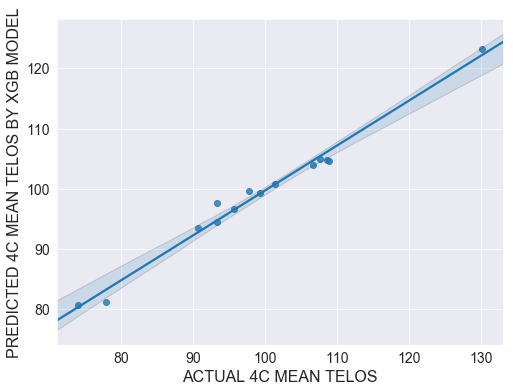

In [237]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=y_true, y=y_xgb_predict)
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY XGB MODEL', fontsize=16)
ax.tick_params(labelsize=14)
# plt.savefig('predicting mean telos 3 months post.png')

## Testing if model can predict 4C mean telomere length using *means

In [226]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
all_patients_4C = trp.combine_data(exploded_telos=exploded_telos_all_patients_df,
                                   all_patients_df=all_patients_df,
                                   prediction_objective='4 C means from telo means')

In [228]:
ML_mean_telos_pre = clean_process_pipe.set_params(cleaner__drop_patient_id=False).fit_transform(all_patients_4C)
ML_mean_telos_clean = ML_mean_telos_pre.copy()

# renaming telos means to enable compatability w/ model
ML_mean_telos_clean.rename(columns={'telo means':'individual telomeres'}, inplace=True)
# dropping to ensure only timepoint/ "individual telomeres" are seen by model
ML_mean_telos_clean.drop(['patient id', '4 C telo means'], axis=1, inplace=True)

In [170]:
pred_4C_telos = model.predict(ML_mean_telos_clean)
pred_4C_telos = pd.DataFrame({'y PREDICT 4C telos': pred_4C_telos})
alpha = pd.concat([ML_mean_telos_pre[['patient id', '4 C telo means']], pred_4C_telos], axis=1)[['patient id', '4 C telo means', 'y PREDICT 4C telos']]
alpha.corr()

,patient id,4 C telo means,y PREDICT 4C telos
patient id,1.000000,-0.508337,-0.339799
4 C telo means,-0.508337,1.000000,0.028171
y PREDICT 4C telos,-0.339799,0.028171,1.000000


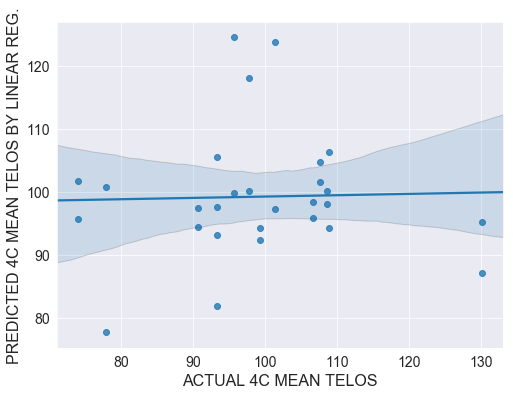

In [171]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=alpha['4 C telo means'], y=alpha['y PREDICT 4C telos'])
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

## Testing if linear regression can predict 4C mean telos using individual telos

In [80]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

fit_lr_model = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean, 
                                         pipe=lr_pipe, model=lr_model, cv=5)

MAE per CV fold: 
[9.58518095 9.48230965 9.47343869 9.49853126 9.54077054] 

MEAN of MAE all folds: 9.516046218212342
STD of MAE all folds: 0.04159623774759664

MAE of predict_y_test & y_test: 9.50851198439441
R2 between predict_y_test & y_test: 0.04627391744688236


In [239]:
y_lr_predict, y_true = trp.predict_target_4C_compare_actual(telo_data=telo_data_qualify, 
                                                           train_set=train_clean, test_set=test_clean, model=lr_model)

patient 1: ACTUAL 4 C telo means: 99.35 --- PREDICTED 4 C telo means: 98.38
patient 2: ACTUAL 4 C telo means: 108.92 --- PREDICTED 4 C telo means: 101.39
patient 3: ACTUAL 4 C telo means: 95.67 --- PREDICTED 4 C telo means: 98.18
patient 5: ACTUAL 4 C telo means: 97.83 --- PREDICTED 4 C telo means: 99.27
patient 6: ACTUAL 4 C telo means: 130.12 --- PREDICTED 4 C telo means: 98.08
patient 7: ACTUAL 4 C telo means: 101.40 --- PREDICTED 4 C telo means: 99.96
patient 8: ACTUAL 4 C telo means: 106.65 --- PREDICTED 4 C telo means: 100.27
patient 9: ACTUAL 4 C telo means: 107.67 --- PREDICTED 4 C telo means: 99.10
patient 10: ACTUAL 4 C telo means: 93.35 --- PREDICTED 4 C telo means: 101.11
patient 11: ACTUAL 4 C telo means: 108.57 --- PREDICTED 4 C telo means: 100.57
patient 12: ACTUAL 4 C telo means: 73.99 --- PREDICTED 4 C telo means: 98.25
patient 14: ACTUAL 4 C telo means: 93.28 --- PREDICTED 4 C telo means: 97.23
patient 15: ACTUAL 4 C telo means: 90.68 --- PREDICTED 4 C telo means: 97.

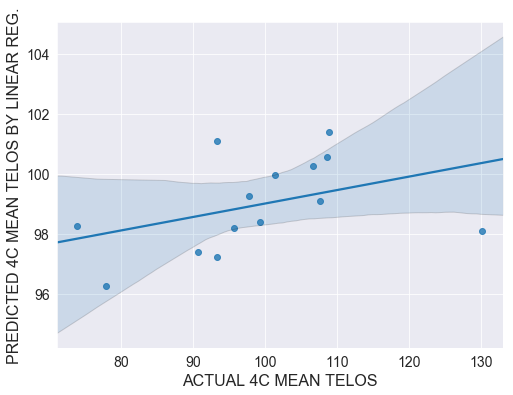

In [240]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=y_true, y=y_lr_predict)
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

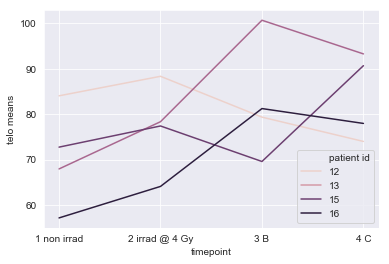

In [396]:
sns.lineplot(x='timepoint', y='telo means', hue='patient id', data=all_patients_df[all_patients_df['patient id'].isin([12, 14, 15, 16])])

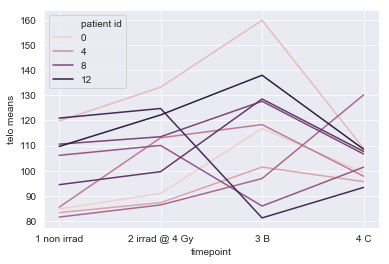

In [393]:
sns.lineplot(x='timepoint', y='telo means', hue='patient id', data=all_patients_df[~all_patients_df['patient id'].isin([12, 13, 14, 15, 16])])

In [137]:
training_MAE = []
test_MAE = []
max_depth_XGB = [3, 4, 5, 10, 15, 20, 25]

X = train_clean[['timepoint_1', 'individual telomeres']]
y = train_clean['4 C telo means']

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=0)

X_test = test_clean[['timepoint_1', 'individual telomeres']]
y_test = test_clean['4 C telo means']

for param in max_depth_XGB:
    model = XGBRegressor(max_depth=param, learning_rate=0.1, n_estimators=100, objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    predict_y_val = model.predict(X_val)
    training_MAE.append(mean_absolute_error(predict_y_val, y_val))
    
    predict_y_test = model.predict(X_test)
    test_MAE.append(mean_absolute_error(predict_y_test, y_test))

In [138]:
viz_traintest_MAE = pd.DataFrame({'training_MAE': training_MAE,
                                  'test_MAE': test_MAE,
                                  'max_depth_XGB': max_depth_XGB})

In [139]:
viz_traintest_MAE = viz_traintest_MAE.melt(id_vars='max_depth_XGB',
                                           value_vars=['training_MAE', 'test_MAE'],
                                           var_name='data type',
                                           value_name='MAE'
                                           )

,max_depth_XGB,data type,MAE
0,3,training_MAE,8.781381
1,4,training_MAE,8.235279
2,5,training_MAE,7.751296
3,10,training_MAE,5.246312
4,15,training_MAE,3.691055


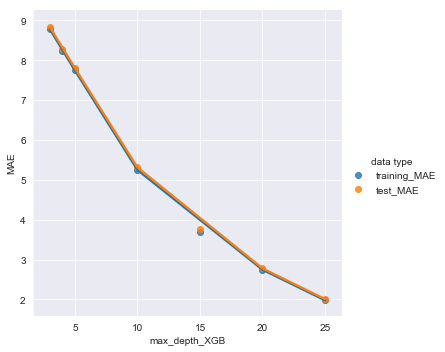

In [140]:
sns.lmplot(x='max_depth_XGB', y='MAE', data=viz_traintest_MAE, hue='data type', lowess=True)

## Visualization

In [80]:
# visualize hyperparameters of XGBoost vs model accuracy
# visualize training vs. test MAE w/ changes params
# visualize fit 

In [526]:
test2 = pd.DataFrame({'predict_y_test': predict_y_test, 'y_test': y_test}).reset_index(drop=True)
test2['residuals'] = test2['predict_y_test'] - test2['y_test']
test2.head()

,predict_y_test,y_test,residuals
0,78.231133,77.956912,0.274221
1,129.140945,130.119423,-0.978477
2,94.292213,93.352615,0.939599
3,129.222321,130.119423,-0.897102
4,94.044617,93.352615,0.692002


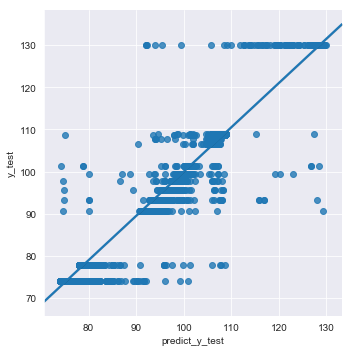

In [527]:
sns.lmplot(x='predict_y_test', y='y_test', data=test2)

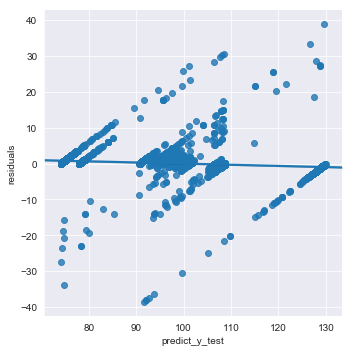

In [504]:
sns.lmplot(x='predict_y_test', y='residuals', data=test2)

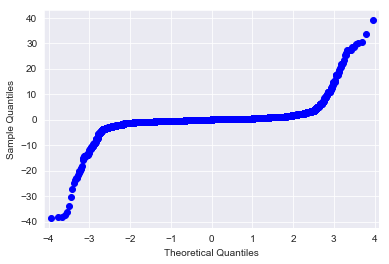

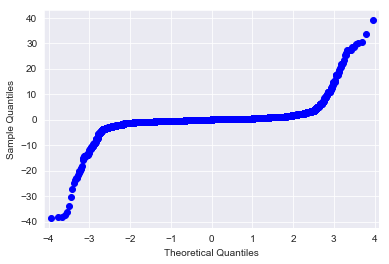

In [505]:
from statsmodels.graphics.gofplots import qqplot
qqplot(test2['residuals'])

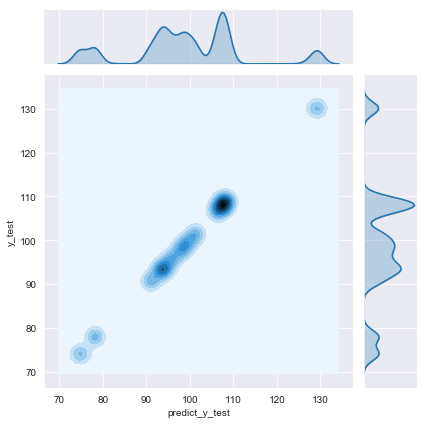

In [506]:
sns.jointplot(x='predict_y_test', y='y_test', kind='kde', data=test2)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [209]:
# loading individual telo data
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')

# loading mean telomere length @ 4 C
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [210]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      prediction_objective='4 C # short telos from individual telos')

quartile_telo_data.head()

,patient id,timepoint,individual telomeres,4 C # short telos
0,1,1 non irrad,92.916201,372.0
1,1,2 irrad @ 4 Gy,112.977654,372.0
2,1,1 non irrad,65.463687,372.0
3,1,2 irrad @ 4 Gy,104.530726,372.0
4,1,1 non irrad,61.240223,372.0


## Train/test split 

In [211]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [249]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [255]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=100, max_depth=12, learning_rate=0.2,
                       objective ='reg:squarederror', random_state=0)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', clean_process_pipe),
                        ('model', model)
                       ])

## Cleaning/modeling data with pipeline

In [256]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = clean_process_pipe.fit_transform(q_test_clean)

## Evaluating model w/ cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [257]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

q_fit_xgb_model = trp.cv_score_fit_mae_test(train_set=q_train_clean, test_set=q_test_clean,
                                            pipe=q_xgb_pipe, model=q_model, cv=5, 
                                            target='4 C # short telos')

MAE per CV fold: 
[0.00015649 0.00015498 0.00015618 0.00015469 0.00015917] 

MEAN of MAE all folds: 0.00015629981615528557
STD of MAE all folds: 1.5896401265051618e-06

MAE of predict_y_test & y_test: 0.00015803745814732144
R2 between predict_y_test & y_test: 0.9999999999999223


In [259]:
q_telo_data_qualify = clean_process_pipe.set_params(cleaner__drop_patient_id=False).fit_transform(quartile_telo_data)

q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=q_telo_data_qualify, 
                                                            train_set=q_train_clean, test_set=q_test_clean, 
                                                            model=q_fit_xgb_model,
                                                            target='4 C # short telos')

ValueError: feature_names mismatch: ['patient id', 'individual telomeres', 'timepoint_1'] ['individual telomeres', 'timepoint_1']
expected patient id in input data

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict)
ax.set_xlabel('ACTUAL 4C # SHORT TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C # SHORT TELOS BY XGB MODEL', fontsize=16)
ax.tick_params(labelsize=14)
# plt.savefig('predicting # short telos 3 months post.png')